In [1]:
import keras
from keras import models
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Activation, Lambda, Conv2D, \
    MaxPooling2D, UpSampling2D,Input, Concatenate, Conv2DTranspose
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

from data_utils import *
import matplotlib.pyplot as plt
import numpy as np
import os
import time

Using TensorFlow backend.


# Load Data

In [2]:
x_train = np.load('./dataset/x_train.npy')
y_train = np.load('./dataset/y_train.npy')
x_test = np.load('./dataset/x_test.npy')
y_test = np.load('./dataset/y_test.npy')

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(213, 64, 64, 1) (213, 64, 64, 1)
(54, 64, 64, 1) (54, 64, 64, 1)


# Segmentation Class U-Net

In [3]:
class UNet(object):
    def __init__(self, img_shape, actf = 'relu',
        learning_rate = 0.001,  drop_rate = 0.5, do_batch_norm = False, do_drop = False):
        
        '''
        Arguments :
        
        img_shape - shape of input image (64, 64, 1)
        actf - activation function for network training
        learning_rate - learning rate for training
        drop_rate - dropout rate
        do_batch_norm - whether to run for batchnormalization
        do_drop - whether to run for dropout
        '''
        
        self.learning_rate = learning_rate
        self.actf = actf
        self.img_shape = img_shape
        self.drop_rate = drop_rate
        self.do_batch_norm = do_batch_norm
        self.do_drop = do_drop

        self.model = self.build_model()
    
    # encoding block(conv - conv - pool)
    def enc_conv_block(self, inputs, feature_maps, filter_size = (3, 3), 
                           conv_strides = 1, pooling_filter_size = (2, 2), pooling_strides = (2, 2)):
        conv1 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides, 
                           padding = 'same', kernel_initializer = 'he_normal')(inputs)
        conv2 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides, 
                           padding = 'same', kernel_initializer = 'he_normal')(conv1)
        pool = MaxPooling2D(pooling_filter_size, strides = pooling_strides)(conv2)
        
        return pool, conv2
    
    # decoding block(concat - upconv - upconv)
    def dec_conv_block(self, inputs, merge_inputs, feature_maps, filter_size = (3, 3), conv_strides = 1,
                           up_conv_strides = (2, 2)):
        
        merge = Concatenate(axis = 3)([Conv2DTranspose(feature_maps, filter_size, 
                                                       activation = self.actf, strides = up_conv_strides, kernel_initializer = 'he_normal', 
                                                       padding = 'same')(inputs), merge_inputs])
                  
        conv1 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides, 
                           padding = 'same', kernel_initializer = 'he_normal')(merge)
        conv2 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides, 
                           padding = 'same', kernel_initializer = 'he_normal')(conv1)
        
        return conv2
    
    # encoder
    def encoding_path(self, inputs):    

        enc_conv1, concat1 = self.enc_conv_block(inputs, 64)
        enc_conv2, concat2 = self.enc_conv_block(enc_conv1, 128)
        enc_conv3, concat3 = self.enc_conv_block(enc_conv2, 256)
        enc_conv4, concat4 = self.enc_conv_block(enc_conv3, 512)
        
        return concat1, concat2, concat3, concat4, enc_conv4
                  
    # decoder
    def decoding_path(self, dec_inputs, concat1, concat2, concat3, concat4):    
        
        dec_conv1 = self.dec_conv_block(dec_inputs, concat4, 512)
        dec_conv2 = self.dec_conv_block(dec_conv1, concat3, 256)
        dec_conv3 = self.dec_conv_block(dec_conv2, concat2, 128)
        dec_conv4 = self.dec_conv_block(dec_conv3, concat1, 64)
        
        return dec_conv4
    # build network
    def build_model(self):
        inputs = Input(self.img_shape)
        
        # Contracting path
        concat1, concat2, concat3, concat4, enc_path = self.encoding_path(inputs)
        
        # middle path
        mid_path1 = Conv2D(1024, (3,3), activation = self.actf, padding = 'same', kernel_initializer = 'he_normal')(enc_path)
        mid_path1 = Dropout(self.drop_rate)(mid_path1)
        mid_path2 = Conv2D(1024, (3,3), activation = self.actf, padding = 'same', kernel_initializer = 'he_normal')(mid_path1)
        mid_path2 = Dropout(self.drop_rate)(mid_path2)
        
        # Expanding path
        dec_path = self.decoding_path(mid_path2, concat1, concat2, concat3, concat4)
        
        decoded = Conv2D(2, (3,3), activation = self.actf, padding = 'same', kernel_initializer = 'he_normal')(dec_path)
        segmented = Conv2D(1, (1,1), activation = 'sigmoid')(decoded)
    
        model = Model(inputs = inputs, outputs = segmented)
        model.compile(optimizer = Adam(lr = self.learning_rate), 
                          loss = 'binary_crossentropy', metrics = [dice_coef])
        
        return model

    # train model
    def train(self, X_train, Y_train, epoch = 10, batch_size = 32, val_split = 0.2, shuffle = True):
      
        self.history = self.model.fit(X_train, Y_train, validation_split = val_split, 
                                          epochs = epoch, batch_size = batch_size, shuffle =  shuffle)
        return self.history
    
    # predict test data
    def predict(self, X_test):
        pred_classes = self.model.predict(X_test)

        return pred_classes
    
    # show u-net architecture
    def show_model(self):
        return print(self.model.summary())

create class

In [4]:
seg_model = UNet(x_train[0].shape,learning_rate = 2e-4, do_drop = True, drop_rate = 0.3)

In [5]:
seg_model.show_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 64)   36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

# Train Model

In [6]:
history = seg_model.train(x_train, y_train, epoch = 100, batch_size = 64)

Train on 170 samples, validate on 43 samples
Epoch 1/100
170/170 [==============================] - 13s 79ms/step - loss: 0.6358 - dice_coef: 0.2936 - val_loss: 0.5884 - val_dice_coef: 0.2370
Epoch 2/100
170/170 [==============================] - 1s 4ms/step - loss: 0.5717 - dice_coef: 0.2571 - val_loss: 0.5392 - val_dice_coef: 0.2582
Epoch 3/100
170/170 [==============================] - 1s 4ms/step - loss: 0.5087 - dice_coef: 0.2878 - val_loss: 0.4043 - val_dice_coef: 0.3639
Epoch 4/100
170/170 [==============================] - 1s 4ms/step - loss: 0.3789 - dice_coef: 0.4138 - val_loss: 0.3441 - val_dice_coef: 0.5036
Epoch 5/100
170/170 [==============================] - 1s 4ms/step - loss: 0.3556 - dice_coef: 0.4841 - val_loss: 0.3170 - val_dice_coef: 0.5177
Epoch 6/100
170/170 [==============================] - 1s 4ms/step - loss: 0.3130 - dice_coef: 0.5045 - val_loss: 0.2633 - val_dice_coef: 0.5692
Epoch 7/100
170/170 [==============================] - 1s 4ms/step - loss: 0.2623 -

Epoch 57/100
170/170 [==============================] - 1s 4ms/step - loss: 0.0517 - dice_coef: 0.9373 - val_loss: 0.0664 - val_dice_coef: 0.9312
Epoch 58/100
170/170 [==============================] - 1s 4ms/step - loss: 0.0498 - dice_coef: 0.9408 - val_loss: 0.0654 - val_dice_coef: 0.9366
Epoch 59/100
170/170 [==============================] - 1s 4ms/step - loss: 0.0475 - dice_coef: 0.9445 - val_loss: 0.0644 - val_dice_coef: 0.9383
Epoch 60/100
170/170 [==============================] - 1s 4ms/step - loss: 0.0472 - dice_coef: 0.9468 - val_loss: 0.0656 - val_dice_coef: 0.9393
Epoch 61/100
170/170 [==============================] - 1s 4ms/step - loss: 0.0458 - dice_coef: 0.9494 - val_loss: 0.0639 - val_dice_coef: 0.9422
Epoch 62/100
170/170 [==============================] - 1s 4ms/step - loss: 0.0442 - dice_coef: 0.9502 - val_loss: 0.0633 - val_dice_coef: 0.9423
Epoch 63/100
170/170 [==============================] - 1s 4ms/step - loss: 0.0435 - dice_coef: 0.9500 - val_loss: 0.0633 - 

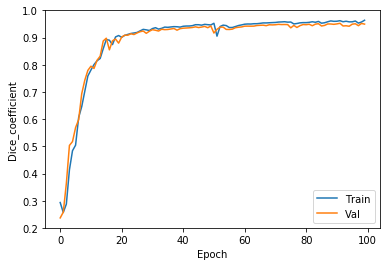

In [7]:
plot_dice(history)

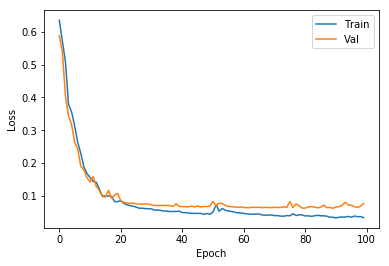

In [8]:
plot_loss(history)

# Show result

In [9]:
preds = seg_model.predict(x_test)

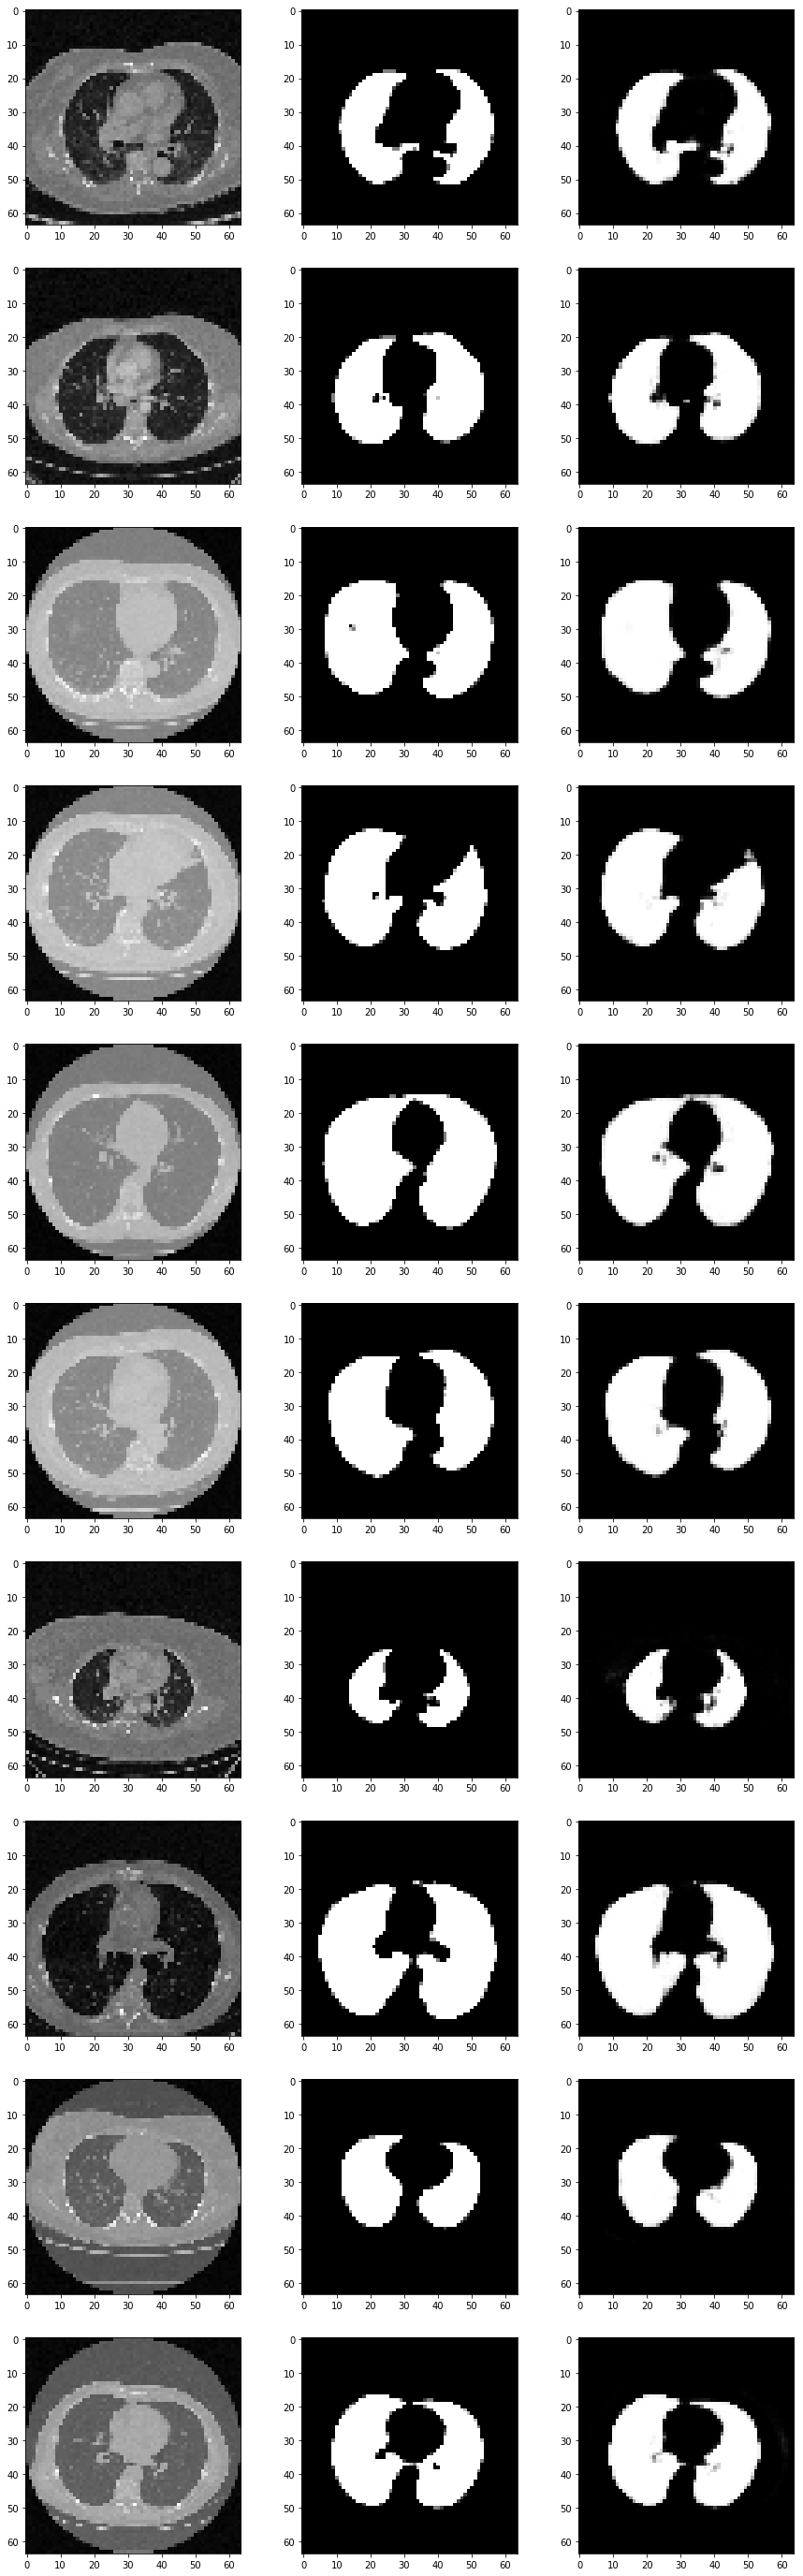

In [10]:
show_num = 10
fig, ax = plt.subplots(show_num, 3, figsize=(15, 50))

for i, pred in enumerate(preds[:show_num]):
    ax[i, 0].imshow(x_test[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_test[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')